# 用GAN生成手写数字

In [ ]:
# 先将 mnist.tar.gz 解压
# mnist 数据集是一个典型的监督训练数据集
# 我们只借助它的训练集即可

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## 用来读取mnist数据的类、

In [2]:
# dataset class

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file)        
        # self.data_df = pandas.read_csv(csv_file, header=None)        
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
        
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        img = img.astype(float)
        plt.figure(figsize=(5,5))
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    def plot_image_from_data(self, image_data):
        plt.figure(figsize=(5,5))
        plt.title("Generated Image")
        plt.imshow(image_data, interpolation='none', cmap='Blues')
        pass
    
    pass

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [4]:
mnist_dataset = MnistDataset('./mnist_train.csv')

In [36]:
mnist_dataset[0]
print(len(mnist_dataset.data_df))

60000


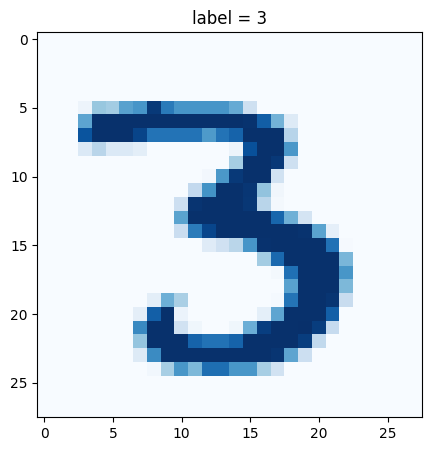

In [9]:
mnist_dataset.plot_image(12)

## 用来生成随机图像的方法（随机种子）

In [6]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

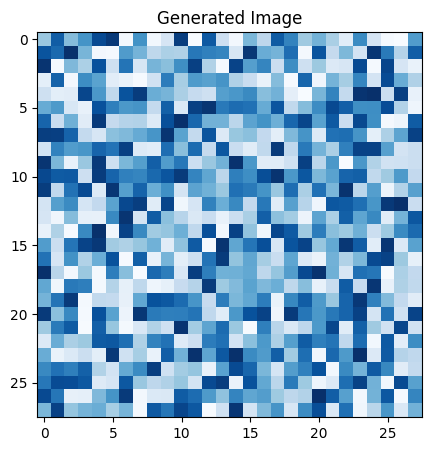

In [7]:
random_image = generate_random_image(784).reshape(28, 28)

mnist_dataset.plot_image_from_data(random_image)


## 判别器网络（Discriminator Network）

In [8]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, device):
        self.device = device
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        ).to(self.device)
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs.to(self.device))
    
    
    def train(self, inputs, targets, batch_size=1):
        # calculate the output of the network
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += batch_size;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## 测试判别器的能力

In [17]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator(device)

CPU times: user 5.36 ms, sys: 0 ns, total: 5.36 ms
Wall time: 2.93 ms


### 训练判别器（单样本）

In [ ]:
for i in range(len(mnist_dataset.data_df)):
        
    label, image_data_tensor, target_tensor = mnist_dataset[i]
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))
    pass

In [22]:
D.forward(mnist_dataset[0][1])

tensor([0.5631], device='cuda:0', grad_fn=<SigmoidBackward>)

### 训练判别器（批量）

In [23]:
batch_size = 10

for i in range(0, len(mnist_dataset.data_df), batch_size):
    inputs = list()
    targets = list()

    for j in range(batch_size):
        label, image_data_tensor, target_tensor = mnist_dataset[i + j]
        inputs.append(image_data_tensor)
        targets.append(label)
    
    inputs = torch.stack(inputs, dim=0)
    fake_inputs = torch.stack([generate_random_image(784) for i in range(batch_size)], dim=0)

    # real data
    D.train(inputs, torch.tensor([[1.0] for i in range(batch_size)]), batch_size)
    # fake data
    D.train(fake_inputs,  torch.tensor([[0.0] for i in range(batch_size)]), batch_size)
    pass
    


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


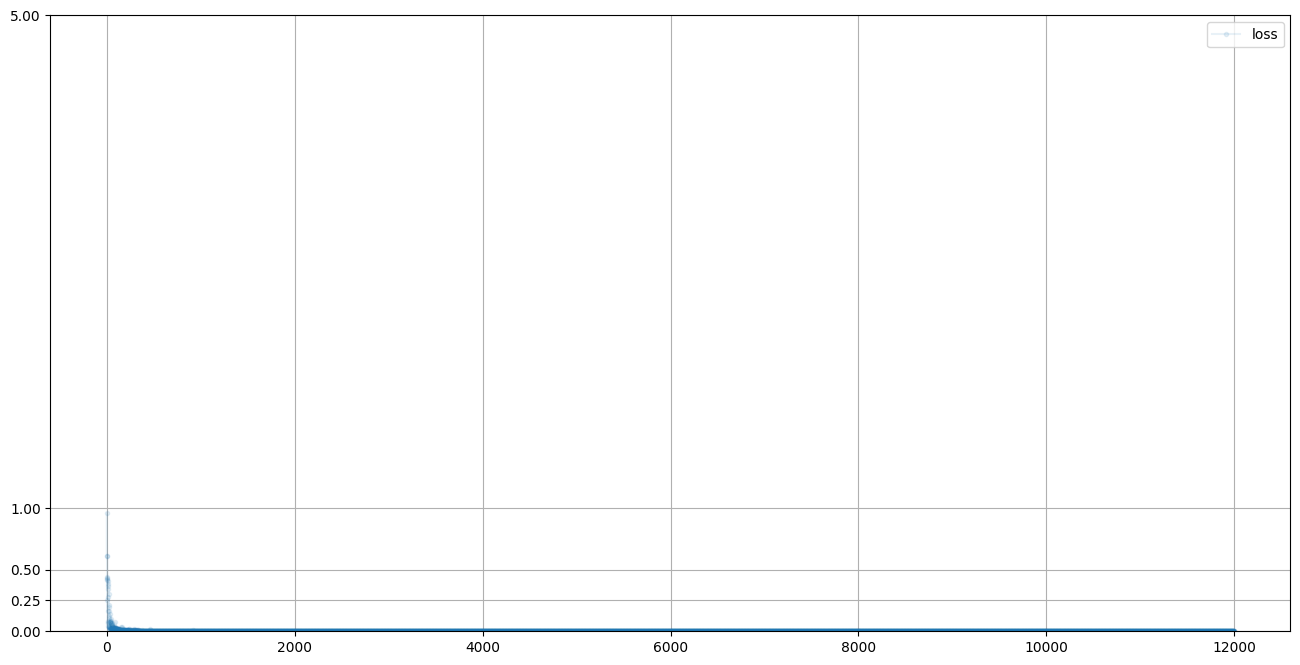

In [24]:
# plot discriminator loss

D.plot_progress()

In [25]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784) ).item() )
  pass

0.9999974966049194
0.9999991655349731
0.9999992847442627
0.9999986886978149
1.1599734079936752e-06
1.000060706246586e-06
9.920228194459924e-07
1.0072287750517717e-06


## 生成器网络（Generator Network）

In [27]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, device):
        # initialise parent pytorch class
        super().__init__()
        self.device = device
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        ).to(self.device)
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs.to(self.device))
    
    
    def train(self, D, inputs, targets, batch_size=1):
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += batch_size;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## 测试生成器的输出

In [14]:
# check the generator output is of the right type and shape

G = Generator(device)


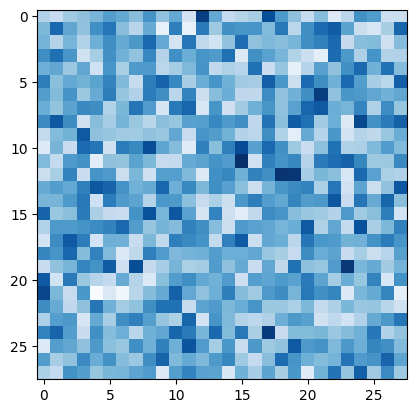

In [15]:
output = G.forward(generate_random_seed(100))

if device == "cuda":
    output = list(map(lambda x: x.cpu(), output))

# print(device)
img = output.detach().cpu().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## 训练GAN

### 单样本训练（时间久 4 epochs 40 min）

In [15]:
%%time 

# create Discriminator and Generator

D = Discriminator(device)
G = Generator(device)

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  # for label, image_data_tensor, target_tensor in mnist_dataset:

  for i in range(len(mnist_dataset.data_df)):
        
    label, image_data_tensor, target_tensor = mnist_dataset[i]

    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 34min 8s, sys: 24.7 s, total: 34min 33s
Wall time: 35min 20s


### 批量训练（速度快, 8 epochs 10min）

In [35]:
%%time 

# create Discriminator and Generator

D = Discriminator(device)
G = Generator(device)

epochs = 8
batch_size = 10

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for i in range(0, len(mnist_dataset.data_df), batch_size):
    inputs = list()
    # targets = list()

    for j in range(batch_size):
        label, image_data_tensor, target_tensor = mnist_dataset[i + j]
        inputs.append(image_data_tensor)
        # targets.append(label)
    
    sample_inputs = torch.stack(inputs, dim=0)
    generate_inputs = torch.stack([G.forward(generate_random_seed(100)).detach() for i in range(batch_size)], dim=0)

    # real data
    D.train(sample_inputs, torch.tensor([[1.0] for i in range(batch_size)]), batch_size)

    # AI made data
    D.train(generate_inputs,  torch.tensor([[0.0] for i in range(batch_size)]), batch_size)

    # train generator
    G.train(D, torch.stack([generate_random_seed(100) for i in range(batch_size)], dim=0), torch.tensor([[1.0] for i in range(batch_size)]), batch_size)

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  5
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000


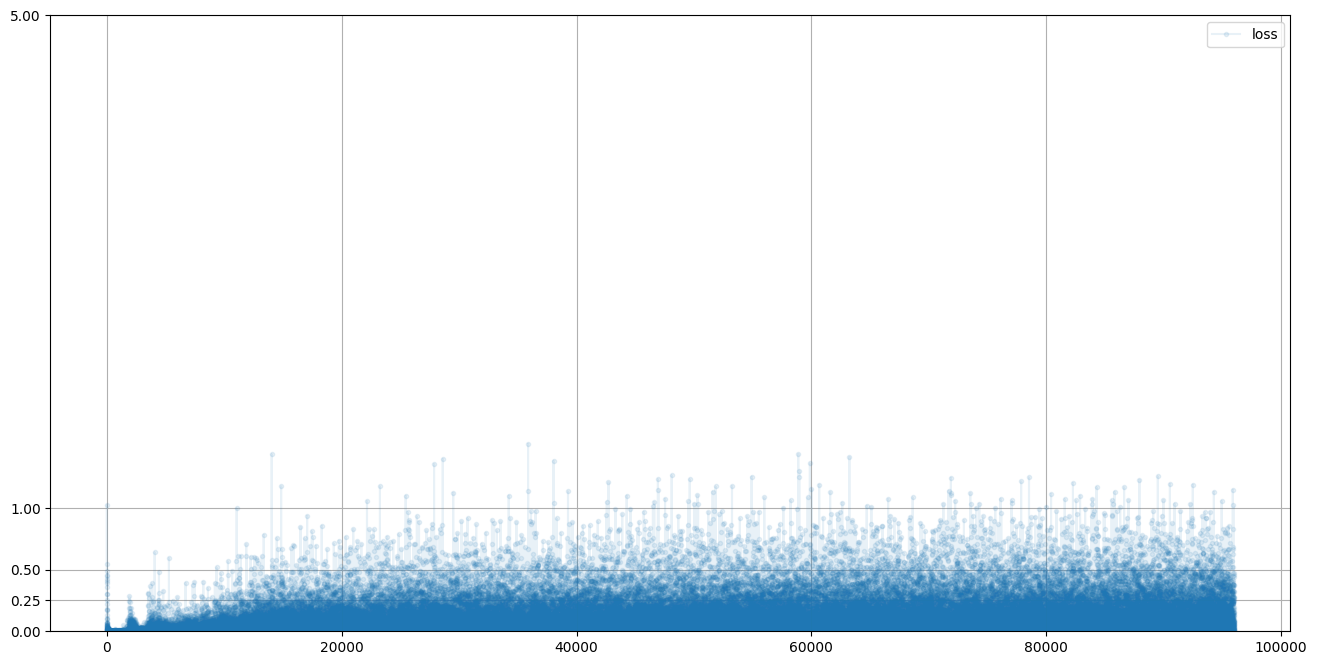

In [37]:
# plot discriminator error

D.plot_progress()

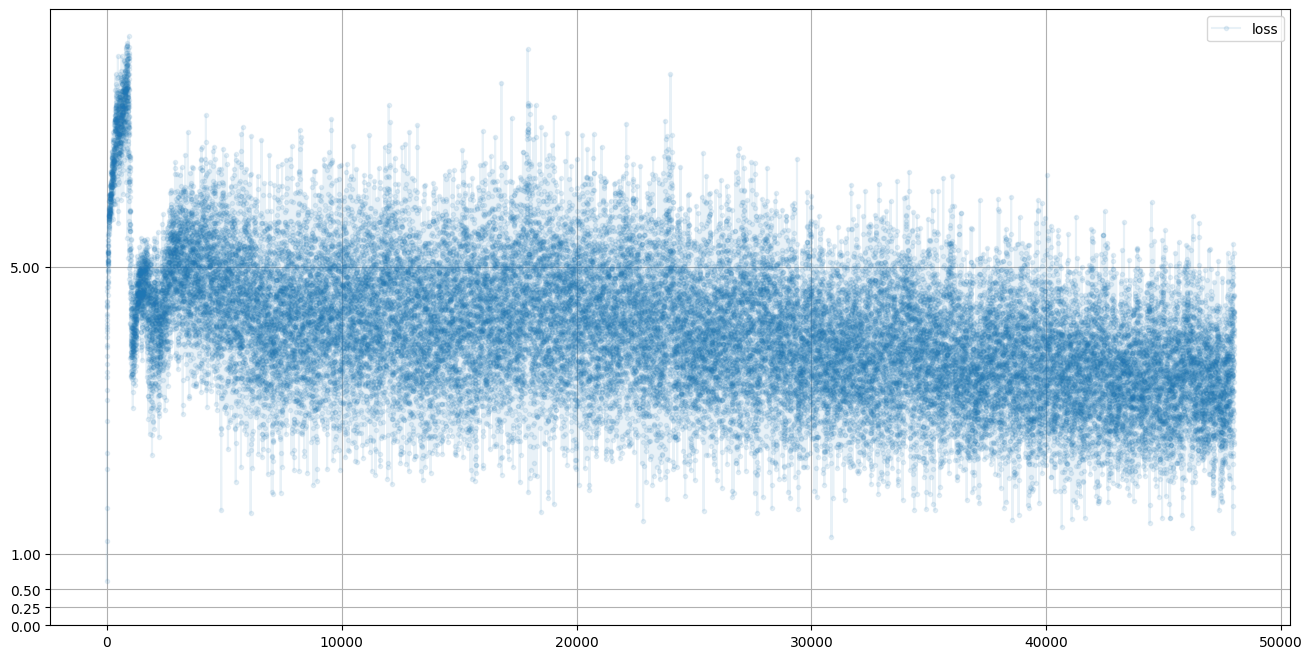

In [38]:
# plot generator error

G.plot_progress()

## Run Generator

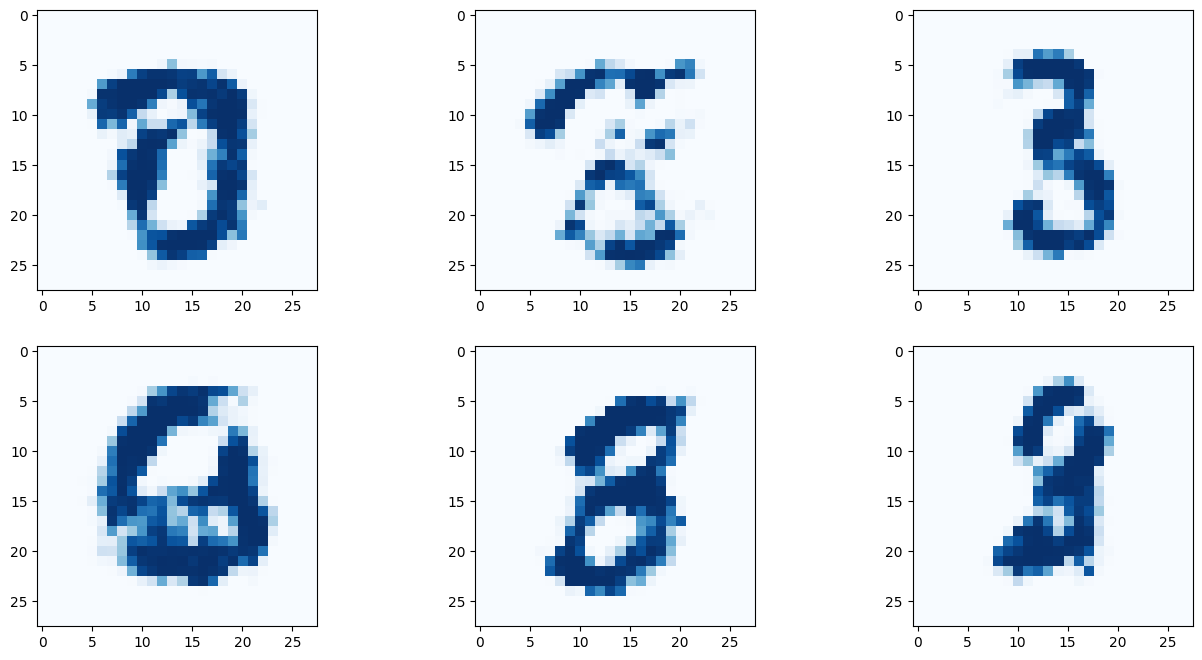

In [53]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100)).cpu()
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

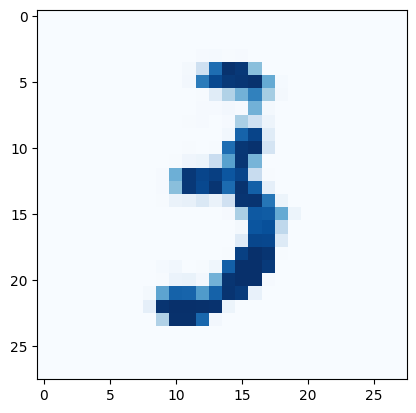

In [55]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.cpu().detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

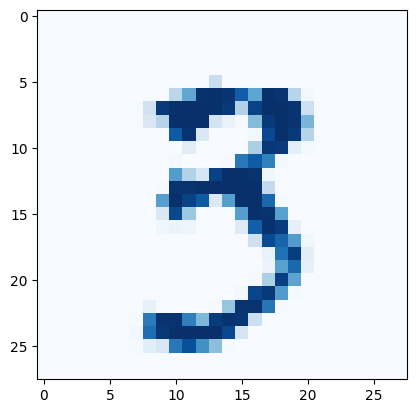

In [56]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.cpu().detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

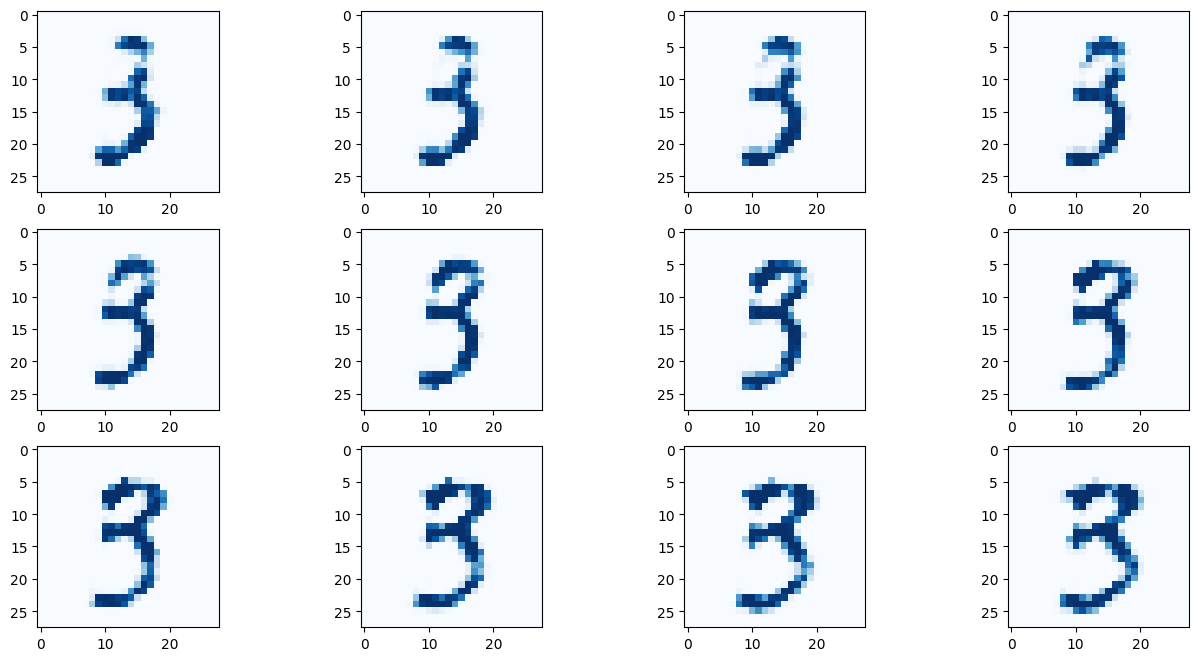

In [59]:
# plot several outputs from the trained generator

count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.cpu().detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

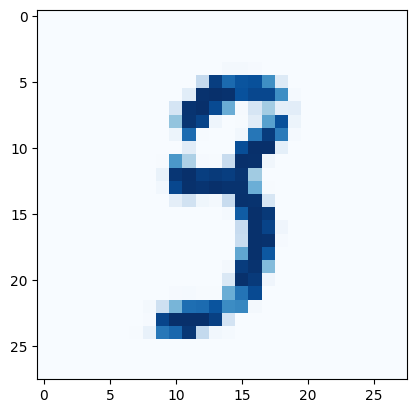

In [61]:
# sum of seeds

seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.cpu().detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

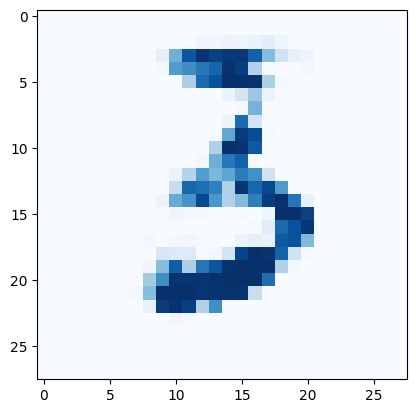

In [62]:
# difference of seeds

seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.cpu().detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

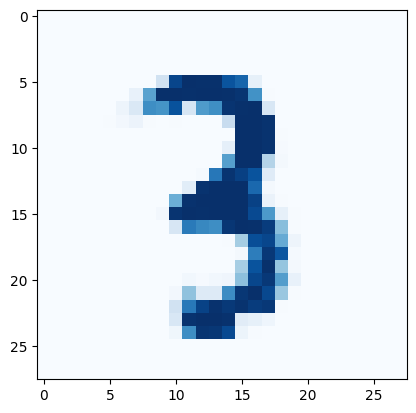

In [63]:
# difference of seeds

seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.cpu().detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')